<a href="https://colab.research.google.com/github/SofiaFreiman/Alternative_Splicing/blob/main/Gene_co_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy leidenalg scikit-misc pyscenic loompy adjustText==0.8
import os
os.kill(os.getpid(), 9)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import loompy as lp
import networkx as nx
from adjustText import adjust_text

sc.settings.verbosity = 1
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

plt.rcParams['font.family'] = 'Liberation Serif'

In [49]:
l2_colors = {'Basal cells': 'tab:green', 'Suprabasal cells': 'darkseagreen', 'Goblet cells': 'mediumaquamarine', 'Secretory cells': 'burlywood', 'Ciliated cells': 'mediumpurple', 'Ionocytes': 'orangered', 'Deuterosomal cells': 'deeppink'}
l3_colors = {'Basal cells' : "tab:green", 'Suprabasal cells' : "darkseagreen", "Goblet cells" : "mediumaquamarine", "Secretory cells" : "burlywood", "Multi-ciliated cells 1" : "cornflowerblue", "Multi-ciliated cells 2" : "mediumpurple", "Ionocytes" : "orangered", "Deuterosomal cells" : "deeppink"}

path = "drive/MyDrive/LU/Pavan_data/"
path_figs = "drive/MyDrive/LU/Pavan_data/figs/"
path_GRN = 'drive/MyDrive/LU/Pavan_data/GRN/'

adata = sc.read(path + "adata_current.h5ad")

In [5]:
# Prepare expression matrix for GRNboost

key_gene = ["TP63", 'KRT5', 'SCGB1A1', 'MUC5B', 'FOXJ1', 'ASCL3'] # These genes include anyway
for i in key_gene:
  if i not in adata.var.index:
    print(i)

loom_path = "input.loom"
loom_path_output = "output.loom"
tfs_path = "drive/MyDrive/LU/GRN/resources/allTFs_hg38.txt"
tfs = [tf.strip() for tf in open(tfs_path)] # Include all TFs

gene_index = adata.var.index.to_series()
ls = gene_index[~gene_index.str.contains(r'-AS|MT-|orf', regex=True)].tolist() # Remove genes we are not interested in. Remember they can connect nodes, so recalculate without this step to check

sc.pp.filter_genes(adata, min_cells = 50)
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, layer = 'counts', flavor = 'seurat_v3')

mask = (
    adata.var.index.isin(ls) &
    (
        (adata.var["highly_variable"] == True) # Keep highly variable
        | adata.var.index.isin(tfs)  # Keep TFs
        | adata.var.index.isin(key_gene)  # Keep lung cell type markers
    )
)

print(adata.shape)
adata = adata[:, mask]
print(adata.shape)

row_attributes = {"Gene": np.array(adata.var.index),}
col_attributes = {"CellID": np.array(adata.obs.index),
    "nGene": np.array(np.sum(adata.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),}

lp.create(loom_path, adata.X.transpose(), row_attributes, col_attributes)

(12516, 3236)
(12516, 3236)


In [ ]:
# GRNboost with arboreto py script

!arboreto_with_multiprocessing.py \
    input.loom \
    drive/MyDrive/LU/GRN/resources/allTFs_hg38.txt \
    --output adj.tsv \
    --method grnboost2 \
    --cell_id_attribute "CellID" \
    --gene_attribute "Gene" \
    --num_workers 40

In [51]:
# Co-expression for 3000 HVGs

adj = pd.read_csv(path_GRN + "adj_3000.tsv", index_col=False, sep="\t")
adj = adj[~adj['target'].str.contains(r'(ENSG|-AS|MT-|orf)')]

In [52]:
# Include marker genes for initial filtering

top = 50

top = adj.sort_values('importance', ascending = False).head(top)
top_names = set(list(top.target) + list(top.TF)+ ["TP63", 'KRT5', 'SCGB1A1', 'MUC5B', 'FOXJ1', 'ASCL3', 'HLF',])

check_TF = adj['TF'].isin(top_names)
check_target = adj['target'].isin(top_names)
subset = adj[check_TF & check_target]

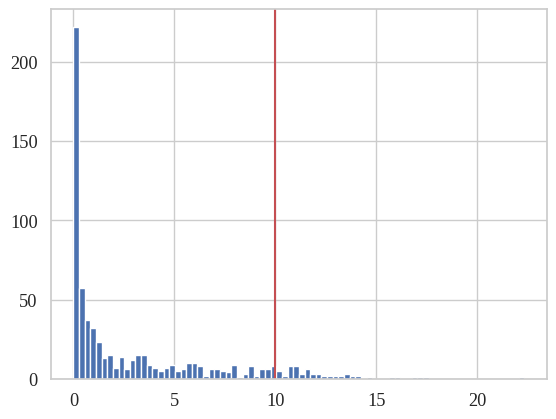

In [53]:
subset.importance.hist(bins = 80)
plt.axvline(10, color = 'r')

In [54]:
gene = "HLF"
adj[(adj.target == gene) | (adj.TF == gene)].sort_values('importance', ascending = False)[:5]

,TF,target,importance
3415,TP63,HLF,3.581060
3763,RPL35,HLF,3.451444
8431,BCL11A,HLF,2.462537
11584,HLF,ZNF423,2.103836
12482,HLF,ZNF90,2.025741


In [60]:
gene = "TP63"
adj[(adj.target == gene) | (adj.TF == gene)].sort_values('importance', ascending = False)[:10]

,TF,target,importance
1293,PRNP,TP63,4.907244
1448,TP63,ELN,4.749078
1780,TP63,MEGF6,4.453055
2135,TP63,EPHB6,4.199608
2606,TP63,LRRC2,3.928516
2747,TP63,TPRG1,3.856735
3025,TP63,AJUBA,3.732159
3161,TP63,NCKAP5,3.675048
3415,TP63,HLF,3.581060
3496,TP63,SNAI2,3.548691


In [57]:
tfs = pd.read_excel(path + "TF_programs.xlsx")
tfs['Basal'].dropna().to_list()

['TP63',
 'ASCL2',
 'ZFP36L2',
 'BCL11A',
 'CNBP',
 'TFDP2',
 'DEK',
 'KMT2A',
 'NR2F2',
 'TSC22D3',
 'NFIB',
 'ARID5B',
 'PURA',
 'ZNF141',
 'HOPX',
 'TFAP2A',
 'DMTF1',
 'ZNF22',
 'ZNF503',
 'NCOR2',
 'STAT2',
 'ZNF385A',
 'NKX2-1',
 'POU3F1',
 'BCL11B',
 'E2F6',
 'RARG',
 'ETS1',
 'SOX15',
 'SLC2A4RG',
 'YBX1',
 'ZNF644']

In [94]:
names = ["HLF", "TP63", "ZFP36L2", "BCL11A", "CNBP", "TFDP2", 'DEK', "STAT2", "MYC"]
importance = 2.8

# Query co-expression data based on chosed importance level for TFs selected from Basal-program
top = adj[((adj.TF.isin(names)) | (adj.target.isin(names))) & (adj.importance > importance)]
top_names = set(list(top.target) + list(top.TF))
top_names.difference_update({'MAFB', 'POU3F1'})
check_TF = adj['TF'].isin(top_names)
check_target = adj['target'].isin(top_names)
subset = adj[check_TF & check_target]

# Prepare adjacency matrix for plotting, all edges lower than chosen importance level are set to zero
subset.loc[subset.importance<importance,'importance'] = 0
pivot = subset.pivot(index='TF', columns='target', values='importance').fillna(0)
index_list = [ind for ind in pivot.columns if ind not in pivot.index]
zero_entries = pd.DataFrame( index = index_list)
pivot = pd.concat([pivot, zero_entries])

# Build the graph
G=nx.from_pandas_adjacency(pivot.fillna(0))

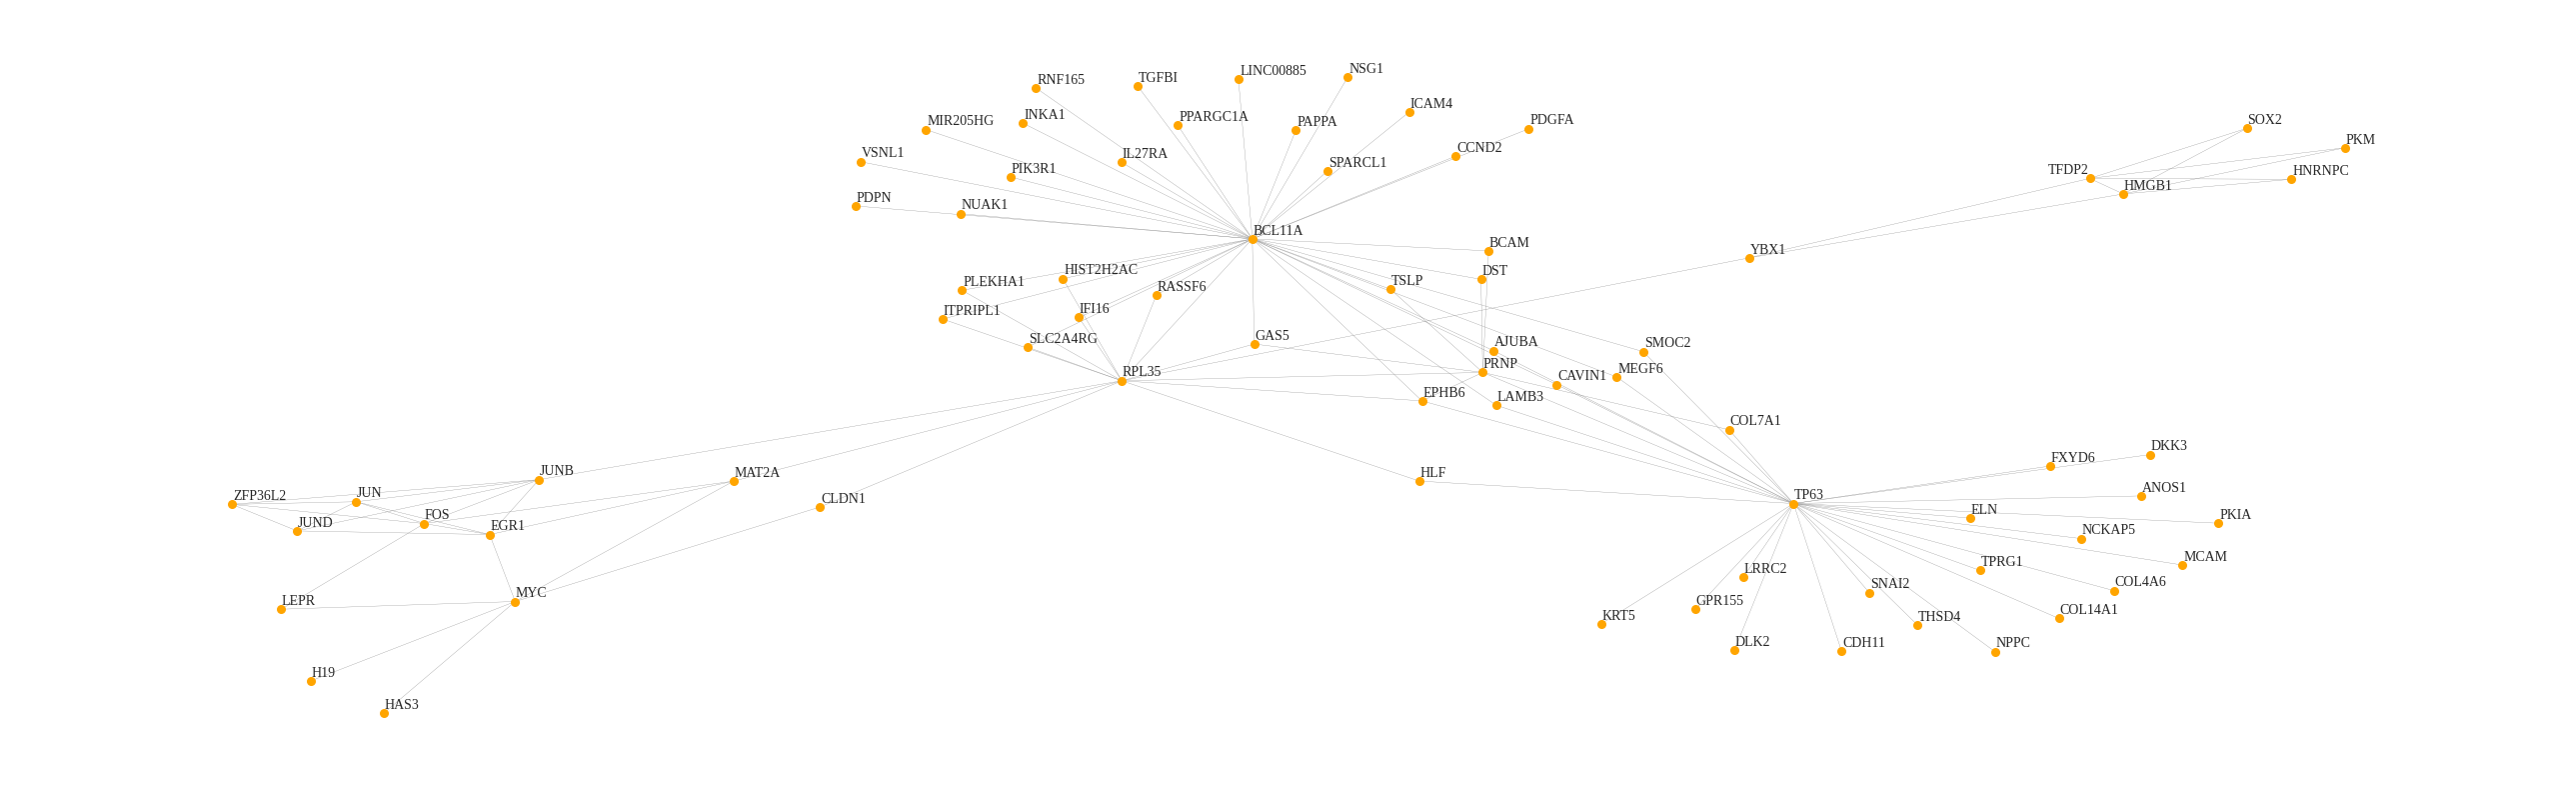

In [92]:
# Plot the network
fig, ax = plt.subplots(1, 1, figsize = (33,10))
pos=nx.spring_layout(G, seed=1)
text = [plt.text(*pos[key], key, fontsize = 10) for key in pos.keys()]
nx.draw(G, with_labels=False, node_color='orange', node_size=30, edge_color='gray', pos = pos, ax=ax, width = 0.2)
adjust_text(text);